# 🏠 AI Room Redesign Studio - Google Colab

Transform your room images and videos with AI-powered interior design!

**Features:**
- ⚡ GPU-accelerated processing (<1 minute for images)
- 🎨 Multiple styles: Modern, Luxury, Minimal, Custom
- 🖼️ Support for images and videos
- 🌐 Web interface with real-time progress

**Instructions:**
1. Enable GPU: Runtime → Change runtime type → GPU
2. Run all cells in order
3. Upload your room image/video when prompted
4. Get your redesigned room!


## 🚀 Setup & Installation

In [1]:
# Check GPU availability
import torch
import os

print("🔍 System Information:")
print(f"Python version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name()}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
else:
    print("⚠️ No GPU detected. Please enable GPU: Runtime → Change runtime type → GPU")

print(f"\n💾 Disk space: {os.statvfs('/').f_bavail * os.statvfs('/').f_frsize / 1e9:.1f} GB available")

🔍 System Information:
Python version: 2.10.0+cu128
CUDA available: True
GPU: Tesla T4
GPU Memory: 15.6 GB

💾 Disk space: 76.2 GB available


In [2]:
# Clone the repository
!git clone https://github.com/Abbastouqi/ai-room-styling.git
%cd ai-room-styling

print("✅ Repository cloned successfully!")

Cloning into 'ai-room-styling'...
remote: Enumerating objects: 68, done.
remote: Counting objects: 100% (68/68), done.
remote: Compressing objects: 100% (58/58), done.
remote: Total 68 (delta 9), reused 66 (delta 8), pack-reused 0 (from 0)
Receiving objects: 100% (68/68), 5.75 MiB | 13.60 MiB/s, done.
Resolving deltas: 100% (9/9), done.
/content/ai-room-styling
✅ Repository cloned successfully!


In [3]:
# Install dependencies
print("📦 Installing dependencies...")

# Install core ML libraries
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install diffusers transformers accelerate safetensors
!pip install ultralytics opencv-python pillow numpy
!pip install flask flask-cors werkzeug
!pip install timm huggingface-hub

# Install SAM
!pip install git+https://github.com/facebookresearch/segment-anything.git

print("✅ Dependencies installed!")

📦 Installing dependencies...
Looking in indexes: https://download.pytorch.org/whl/cu118
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 33.6 MB/s eta 0:00:00
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-lcef1fxd
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-lcef1fxd
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
  Created wheel for segment_anything: filename=segment_anything-1.0-py3-none-any.whl size=36592 sha256=0e259070aa62a7b0aaece69a71c852136fe7ac6320ffbf03de4c90e85e7234b4
  Stored in directory: /tmp/pip-ephem-wheel-cache-keyzxkhg/wheels/29/82/ff/04e2be9805a1cb48bec0b85b5a6da6b63f647645750a0e42d4
Successfully built segment_anything
✅ Dependencies installed!


In [4]:
# Download required models
print("🔽 Downloading models...")

import os
import urllib.request
from pathlib import Path

# Create models directory
os.makedirs('models', exist_ok=True)

# Download SAM model
sam_url = "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth"
sam_path = "models/sam_vit_b.pth"

if not os.path.exists(sam_path):
    print("Downloading SAM model (375MB)...")
    urllib.request.urlretrieve(sam_url, sam_path)
    print("✅ SAM model downloaded")
else:
    print("✅ SAM model already exists")

# YOLOv8 will be downloaded automatically by ultralytics
print("✅ Models ready!")

🔽 Downloading models...
✅ SAM model downloaded
✅ Models ready!


## 🎨 Usage Methods

Choose one of the methods below:

### Method 1: 🌐 Web Interface (Recommended)

Run the full web application with beautiful UI

In [5]:
# Method 1: Web Interface with ngrok
!pip install pyngrok

from pyngrok import ngrok
import threading
import time
import sys
sys.path.append('/content/ai-room-styling')

# Set ngrok auth token (optional - get free token from ngrok.com)
# ngrok.set_auth_token("your_token_here")

def start_backend():
    """Start Flask backend"""
    os.chdir('/content/ai-room-styling/backend')
    os.system('python app.py')

# Start backend in background
backend_thread = threading.Thread(target=start_backend, daemon=True)
backend_thread.start()

# Wait for backend to start
time.sleep(5)

# Create ngrok tunnel
public_url = ngrok.connect(5000)
print(f"🌐 Backend API: {public_url}")

# Serve frontend
os.chdir('/content/ai-room-styling/frontend')
frontend_url = ngrok.connect(8080)
print(f"🎨 Frontend UI: {frontend_url}")
print("\n🚀 Click the Frontend UI link above to access the web interface!")
print("📝 Note: Update the API URL in script.js if needed")

# Start frontend server
!python -m http.server 8080

ERROR:pyngrok.process.ngrok:t=2026-02-21T18:06:55+0000 lvl=eror msg="failed to reconnect session" obj=tunnels.session err="authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your authtoken: https://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_4018\r\n"
ERROR:pyngrok.process.ngrok:t=2026-02-21T18:06:55+0000 lvl=eror msg="session closing" obj=tunnels.session err="authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your authtoken: https://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_4018\r\n"
ERROR:pyngrok.process.ngrok:t=2026-02-21T18:06:55+0000 lvl=eror msg="terminating with error" obj=app err="authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your aut

PyngrokNgrokError: The ngrok process errored on start: authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your authtoken: https://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_4018\r\n.

### Method 2: 📱 Simple Upload Interface

Upload files directly in Colab and process them

🎨 AI Room Redesign - Simple Interface
📁 Upload your room image or video below:


Saving WhatsApp Image 2026-02-21 at 11.08.21 PM.jpeg to WhatsApp Image 2026-02-21 at 11.08.21 PM.jpeg
Saving WhatsApp Image 2026-02-21 at 11.08.10 PM.jpeg to WhatsApp Image 2026-02-21 at 11.08.10 PM.jpeg
Saving WhatsApp Image 2026-02-21 at 11.08.04 PM.jpeg to WhatsApp Image 2026-02-21 at 11.08.04 PM.jpeg

📂 Processing: WhatsApp Image 2026-02-21 at 11.08.21 PM.jpeg
✅ Saved to: /content/ai-room-styling/data/input/WhatsApp Image 2026-02-21 at 11.08.21 PM.jpeg

🖼️ Original Image:


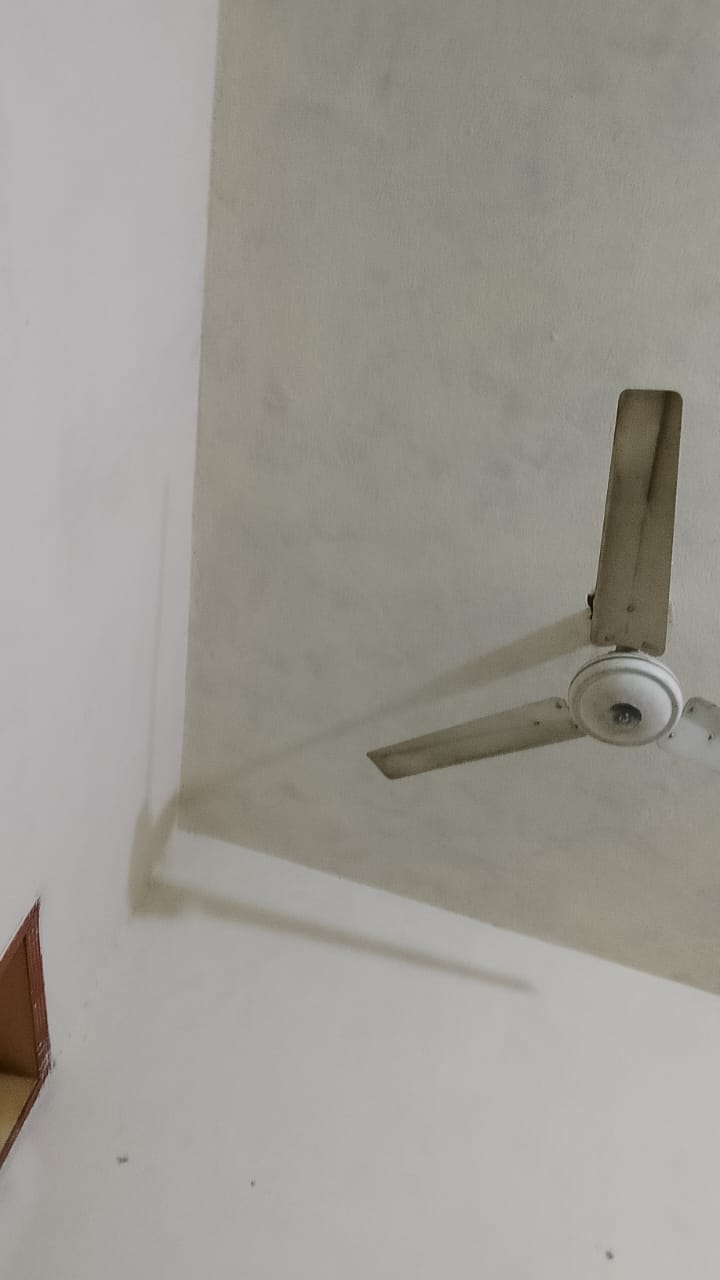


📂 Processing: WhatsApp Image 2026-02-21 at 11.08.10 PM.jpeg
✅ Saved to: /content/ai-room-styling/data/input/WhatsApp Image 2026-02-21 at 11.08.10 PM.jpeg

🖼️ Original Image:


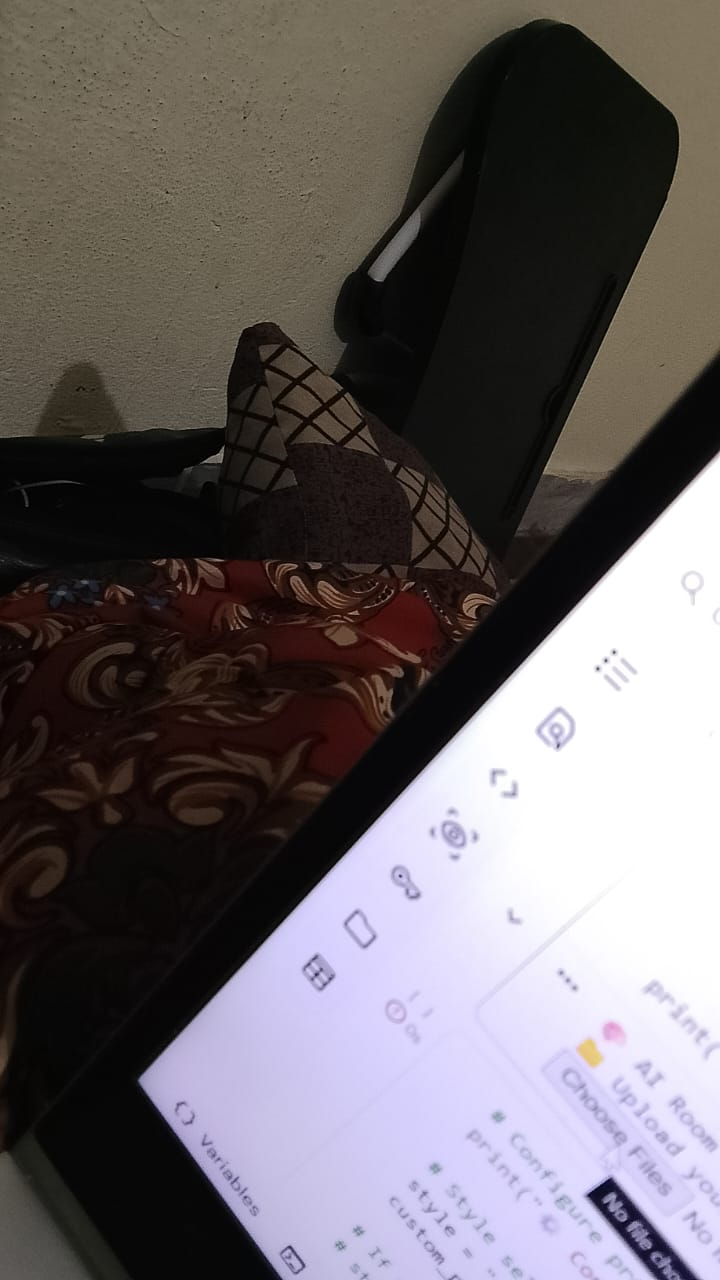


📂 Processing: WhatsApp Image 2026-02-21 at 11.08.04 PM.jpeg
✅ Saved to: /content/ai-room-styling/data/input/WhatsApp Image 2026-02-21 at 11.08.04 PM.jpeg

🖼️ Original Image:


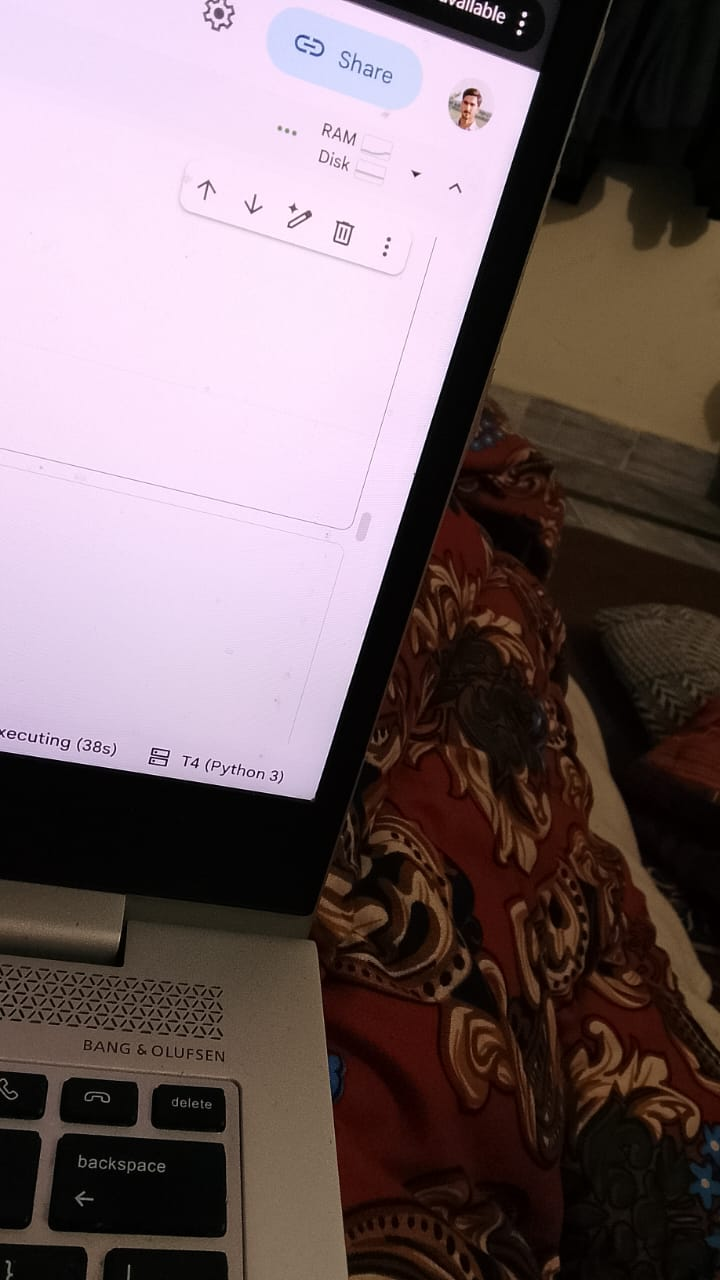


✅ Upload complete! Run the next cell to process.


In [6]:
# Method 2: Simple Colab Interface
import sys
sys.path.append('/content/ai-room-styling')

from google.colab import files
import asyncio
import os
from pathlib import Path
from IPython.display import Image, display, HTML
import matplotlib.pyplot as plt
from PIL import Image as PILImage
import numpy as np

# Import our optimized pipeline
from src.optimized_pipeline import OptimizedPipeline, OptimizationConfig

print("🎨 AI Room Redesign - Simple Interface")
print("📁 Upload your room image or video below:")

# Upload files
uploaded = files.upload()

# Process uploaded files
for filename in uploaded.keys():
    print(f"\n📂 Processing: {filename}")

    # Save uploaded file
    input_path = f"/content/ai-room-styling/data/input/{filename}"
    os.makedirs(os.path.dirname(input_path), exist_ok=True)

    with open(input_path, 'wb') as f:
        f.write(uploaded[filename])

    print(f"✅ Saved to: {input_path}")

    # Show original image if it's an image
    if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
        print("\n🖼️ Original Image:")
        display(Image(input_path, width=400))

print("\n✅ Upload complete! Run the next cell to process.")

INFO:__main__:Using GPU: Tesla T4
INFO:__main__:Pre-loading models...
INFO:__main__:Loading SAM model...
INFO:__main__:Loading YOLO model...
INFO:__main__:✅ YOLO model loaded
INFO:__main__:Loading Depth Estimation model...


⚙️ Configuration:
Style: modern
✅ SAM model already present.

🚀 Initializing pipeline (GPU: True)...


Loading weights:   0%|          | 0/414 [00:00<?, ?it/s]

INFO:__main__:✅ SAM model loaded
INFO:__main__:Loading Diffusion and ControlNet models...
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_validators.py:202: UserWarning: The `local_dir_use_symlinks` argument is deprecated and ignored in `hf_hub_download`. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(
INFO:__main__:✅ Depth Estimation model loaded


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/396 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/196 [00:00<?, ?it/s]

INFO:__main__:✅ Diffusion and ControlNet models loaded
INFO:__main__:✅ All models pre-loaded
INFO:__main__:Processing image: /content/ai-room-styling/data/input/WhatsApp Image 2026-02-21 at 11.08.21 PM.jpeg with style modern
INFO:__main__:Estimating depth...
INFO:__main__:Generating redesign for prompt: A modern living room interior design, clean lines, minimalist, functional, light colors, sleek furniture.



📁 Found 3 file(s) to process

🎨 Starting AI room redesign...
⏱️ This may take 30-60 seconds with GPU, 5-10 minutes with CPU. Videos will take significantly longer.


  0%|          | 0/20 [00:00<?, ?it/s]

INFO:__main__:Processing image: /content/ai-room-styling/data/input/WhatsApp Image 2026-02-21 at 11.08.04 PM.jpeg with style modern
INFO:__main__:Estimating depth...
INFO:__main__:Generating redesign for prompt: A modern living room interior design, clean lines, minimalist, functional, light colors, sleek furniture.


  0%|          | 0/20 [00:00<?, ?it/s]

INFO:__main__:Processing image: /content/ai-room-styling/data/input/WhatsApp Image 2026-02-21 at 11.08.10 PM.jpeg with style modern
INFO:__main__:Estimating depth...
INFO:__main__:Generating redesign for prompt: A modern living room interior design, clean lines, minimalist, functional, light colors, sleek furniture.


  0%|          | 0/20 [00:00<?, ?it/s]

INFO:__main__:Saved redesigned image to /content/ai-room-styling/data/output/WhatsApp Image 2026-02-21 at 11.08.21 PM_redesigned.png
INFO:__main__:Saved redesigned image to /content/ai-room-styling/data/output/WhatsApp Image 2026-02-21 at 11.08.04 PM_redesigned.png
INFO:__main__:Saved redesigned image to /content/ai-room-styling/data/output/WhatsApp Image 2026-02-21 at 11.08.10 PM_redesigned.png



✅ Processing complete in 13.0 seconds!
📁 Results saved to: /content/ai-room-styling/data/output

🎨 Results:

📸 WhatsApp Image 2026-02-21 at 11.08.21 PM.jpeg → WhatsApp Image 2026-02-21 at 11.08.21 PM_redesigned.png


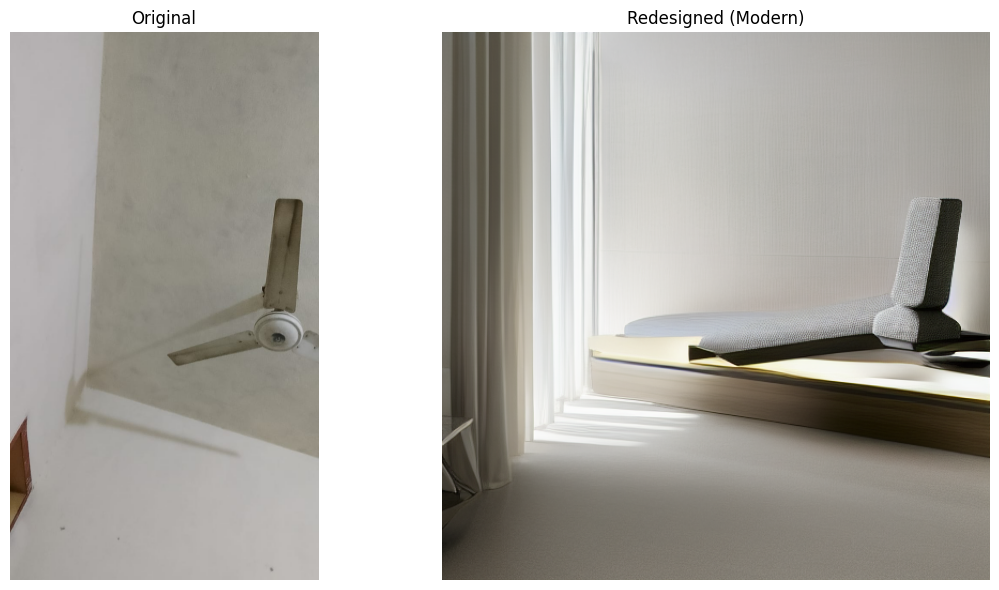

💾 Download: /content/ai-room-styling/data/output/WhatsApp Image 2026-02-21 at 11.08.21 PM_redesigned.png

📸 WhatsApp Image 2026-02-21 at 11.08.04 PM.jpeg → WhatsApp Image 2026-02-21 at 11.08.04 PM_redesigned.png


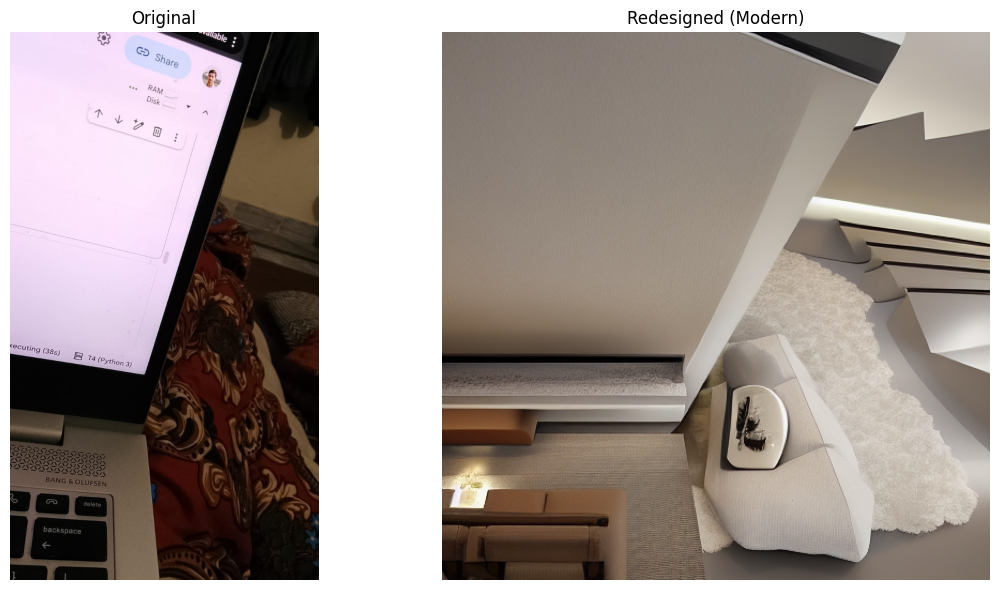

💾 Download: /content/ai-room-styling/data/output/WhatsApp Image 2026-02-21 at 11.08.04 PM_redesigned.png

📸 WhatsApp Image 2026-02-21 at 11.08.10 PM.jpeg → WhatsApp Image 2026-02-21 at 11.08.10 PM_redesigned.png


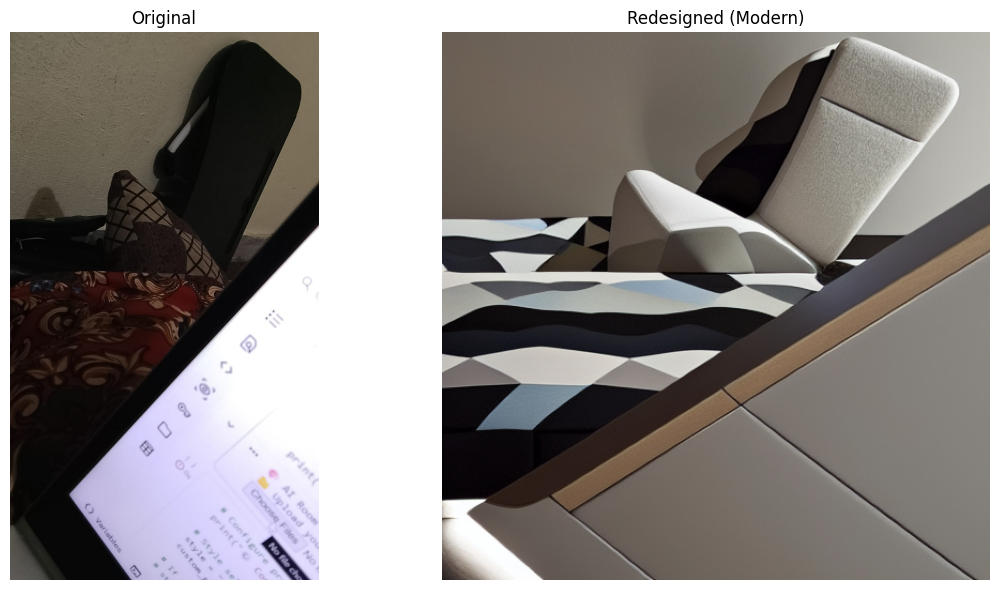

💾 Download: /content/ai-room-styling/data/output/WhatsApp Image 2026-02-21 at 11.08.10 PM_redesigned.png


INFO:__main__:Cleanup complete.



🎉 All done! You can download the results from the files panel.


In [2]:
import sys
sys.path.append('/content/ai-room-styling')

import os
import torch
from concurrent.futures import ThreadPoolExecutor, as_completed
import logging
from pathlib import Path
import cv2
import numpy as np
from PIL import Image as PILImage
from IPython.display import Image, display, HTML, Video
import matplotlib.pyplot as plt

# Import necessary utilities
import torch.nn.functional as F
from torchvision.transforms import ToTensor, ToPILImage

# Suppress some common warnings
logging.getLogger("diffusers").setLevel(logging.ERROR)
logging.getLogger("transformers").setLevel(logging.ERROR)
logging.getLogger("ultralytics").setLevel(logging.ERROR)

from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler
from transformers import DPTForDepthEstimation, DPTImageProcessor
from segment_anything import sam_model_registry, SamPredictor
from ultralytics import YOLO

logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

class OptimizationConfig:
    def __init__(self, use_gpu: bool = True, batch_size: int = 1, use_fp16: bool = True,
                 cache_models: bool = True, parallel_stages: bool = True,
                 memory_efficient: bool = True):
        self.use_gpu = use_gpu
        self.batch_size = batch_size
        self.use_fp16 = use_fp16
        self.cache_models = cache_models
        self.parallel_stages = parallel_stages
        self.memory_efficient = memory_efficient

class OptimizedPipeline:
    def __init__(self, config: OptimizationConfig):
        self.config = config
        self.device = self._setup_device()
        self.executor = ThreadPoolExecutor(max_workers=min(2, os.cpu_count() or 1))

        self.sam_model = None
        self.sam_predictor = None
        self.yolo_model = None
        self.depth_estimator = None
        self.depth_image_processor = None
        self.controlnet = None
        self.diffusion_pipeline = None

        self.sam_checkpoint_path = "models/sam_vit_b.pth"
        self.yolo_model_name = "yolov8n.pt"

        if self.config.cache_models:
            self._preload_models()

    def _setup_device(self) -> torch.device:
        if self.config.use_gpu and torch.cuda.is_available():
            logger.info(f"Using GPU: {torch.cuda.get_device_name(0)}")
            return torch.device("cuda")
        else:
            logger.info("Using CPU")
            return torch.device("cpu")

    def _preload_models(self):
        logger.info("Pre-loading models...")
        futures = []
        futures.append(self.executor.submit(self._load_segmentation_model))
        futures.append(self.executor.submit(self._load_detection_model))
        futures.append(self.executor.submit(self._load_depth_estimation_model))
        futures.append(self.executor.submit(self._load_diffusion_model))

        for future in as_completed(futures): # Use as_completed for better progress indication
            future.result() # This will re-raise exceptions from the threads

        logger.info("✅ All models pre-loaded")

    def _load_segmentation_model(self):
        if self.sam_model is None:
            logger.info("Loading SAM model...")
            sam_model_architecture = sam_model_registry["vit_b"](checkpoint=None)
            sam_model_architecture.eval()

            self.sam_model = sam_model_architecture.to_empty(device=self.device)
            state_dict = torch.load(self.sam_checkpoint_path, map_location=self.device)
            self.sam_model.load_state_dict(state_dict)

            self.sam_predictor = SamPredictor(self.sam_model)
            logger.info("✅ SAM model loaded")
        return self.sam_predictor

    def _load_detection_model(self):
        if self.yolo_model is None:
            logger.info("Loading YOLO model...")
            self.yolo_model = YOLO(self.yolo_model_name)
            self.yolo_model.to(self.device)
            logger.info("✅ YOLO model loaded")
        return self.yolo_model

    def _load_depth_estimation_model(self):
        if self.depth_estimator is None:
            logger.info("Loading Depth Estimation model...")
            self.depth_estimator = DPTForDepthEstimation.from_pretrained("Intel/dpt-hybrid-midas")
            self.depth_image_processor = DPTImageProcessor.from_pretrained("Intel/dpt-hybrid-midas")
            if self.config.use_fp16 and self.device.type == 'cuda':
                self.depth_estimator.half()
            self.depth_estimator.to(self.device)
            logger.info("✅ Depth Estimation model loaded")
        return self.depth_estimator, self.depth_image_processor

    def _load_diffusion_model(self):
        if self.diffusion_pipeline is None:
            logger.info("Loading Diffusion and ControlNet models...")
            self.controlnet = ControlNetModel.from_pretrained(
                "lllyasviel/sd-controlnet-depth", torch_dtype=torch.float16 if self.config.use_fp16 else torch.float32
            )
            self.diffusion_pipeline = StableDiffusionControlNetPipeline.from_pretrained(
                "runwayml/stable-diffusion-v1-5", controlnet=self.controlnet,
                torch_dtype=torch.float16 if self.config.use_fp16 else torch.float32
            )
            self.diffusion_pipeline.scheduler = UniPCMultistepScheduler.from_config(self.diffusion_pipeline.scheduler.config)
            self.diffusion_pipeline.to(self.device)
            logger.info("✅ Diffusion and ControlNet models loaded")
        return self.diffusion_pipeline

    # New method to perform segmentation
    def _segment_image(self, image: PILImage.Image) -> np.ndarray:
        logger.info("Performing semantic segmentation...")
        predictor = self._load_segmentation_model()
        predictor.set_image(np.array(image))
        H, W = image.size[1], image.size[0]
        boxes = self._load_detection_model()(image, verbose=False)[0].boxes.xyxy # Use YOLO to get bounding boxes
        if len(boxes) == 0:
            logger.warning("No objects detected by YOLO, proceeding without segmentation masks.")
            # Return a blank mask if no objects are detected
            return np.zeros((H, W), dtype=np.uint8)

        masks, _, _ = predictor.predict(box=boxes.cpu().numpy(), multimask_output=False)
        # Combine masks into a single foreground mask
        combined_mask = np.any(masks, axis=0)
        return combined_mask.astype(np.uint8) * 255 # Return a binary mask

    # New method to estimate depth
    def _estimate_depth(self, image: PILImage.Image) -> PILImage.Image:
        logger.info("Estimating depth...")
        depth_estimator, depth_image_processor = self._load_depth_estimation_model()

        # Resize image to model input size if necessary
        if image.size != (depth_image_processor.size["width"], depth_image_processor.size["height"]):
            original_size = image.size
            image = image.resize((depth_image_processor.size["width"], depth_image_processor.size["height"])) # Resize for DPT input

        pixel_values = depth_image_processor(image, return_tensors="pt").pixel_values.to(self.device)

        # Convert pixel_values to half precision if use_fp16 is true
        if self.config.use_fp16 and self.device.type == 'cuda':
            pixel_values = pixel_values.half()

        with torch.no_grad():
            depth_output = depth_estimator(pixel_values).predicted_depth

        depth_map = torch.nn.functional.interpolate(
            depth_output.unsqueeze(1),
            size=original_size[::-1], # PIL image size is (width, height), interpolate expects (height, width)
            mode="bicubic",
            align_corners=False,
        ).squeeze()

        depth_min = torch.amin(depth_map, dim=[0, 1], keepdim=True)
        depth_max = torch.amax(depth_map, dim=[0, 1], keepdim=True)
        depth_map = (depth_map - depth_min) / (depth_max - depth_min)
        depth_map = (depth_map * 255).cpu().numpy().astype(np.uint8)
        return PILImage.fromarray(depth_map)

    # New method to generate redesign using diffusion
    def _generate_redesign(self, image: PILImage.Image, depth_map: PILImage.Image, prompt: str, negative_prompt: str = "lowres, bad anatomy, bad hands, text, error, missing fingers, extra digit, fewer digits, cropped, worst quality, low quality, normal quality, jpeg artifacts, signature, watermark, username, blurry"): # Added negative prompt
        logger.info(f"Generating redesign for prompt: {prompt}")
        pipeline = self._load_diffusion_model()

        # Resize depth map to match diffusion model's expected control_image size if needed
        if depth_map.size != (512, 512): # Common size for ControlNet-Depth models
            depth_map = depth_map.resize((512, 512))

        # Resize input image to match diffusion model's expected input size
        if image.size != (512, 512):
            image = image.resize((512, 512))

        generated_image = pipeline(
            prompt,
            image=depth_map, # ControlNet-Depth uses depth map as conditioning
            negative_prompt=negative_prompt,
            num_inference_steps=20,
        ).images[0]
        return generated_image.resize(image.size) # Resize back to original if input image was resized

    async def _process_video(self, video_path: str, style: str, custom_prompt: str, output_dir: Path):
        logger.info(f"Processing video: {video_path} with style {style}")
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            raise IOError(f"Could not open video file {video_path}")

        frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        fps = cap.get(cv2.CAP_PROP_FPS)
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

        output_video_path = output_dir / f"{Path(video_path).stem}_redesigned.mp4"
        fourcc = cv2.VideoWriter_fourcc(*'mp4v') # Codec for .mp4
        out = cv2.VideoWriter(str(output_video_path), fourcc, fps, (frame_width, frame_height))

        processed_frames = []
        frame_count = 0

        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame_count += 1
            logger.info(f"Processing frame {frame_count}/{total_frames} for {video_path}")

            # Convert OpenCV BGR frame to PIL RGB image
            img_pil = PILImage.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

            # 2. Estimate Depth
            depth_map = self._estimate_depth(img_pil)

            # 3. Determine prompt based on style
            if style == "modern":
                design_prompt = "A modern living room interior design, clean lines, minimalist, functional, light colors, sleek furniture."
            elif style == "luxury":
                design_prompt = "A luxurious and opulent room interior design, rich textures, elegant furniture, sophisticated decor, warm lighting."
            elif style == "minimal":
                design_prompt = "A minimalist room interior design, spacious, simple, uncluttered, neutral color palette, essential furniture."
            elif style == "custom" and custom_prompt:
                design_prompt = custom_prompt
            else:
                design_prompt = "A beautifully designed room interior."

            # 4. Generate redesigned image
            redesigned_img_pil = self._generate_redesign(img_pil, depth_map, design_prompt)

            # Convert PIL RGB image back to OpenCV BGR frame
            redesigned_frame = cv2.cvtColor(np.array(redesigned_img_pil), cv2.COLOR_RGB2BGR)
            out.write(redesigned_frame)
            processed_frames.append(redesigned_img_pil) # Keep track for potential display or further use

        cap.release()
        out.release()
        logger.info(f"Finished processing video: {video_path}. Output saved to {output_video_path}")
        return {"input_path": video_path, "output_video_path": str(output_video_path), "style": style}

    async def process_batch(self, input_paths: list[str], style: str = "modern", custom_prompt: str = None):
        results = []
        output_dir = Path("/content/ai-room-styling/data/output") # Define output_dir here for video processing
        output_dir.mkdir(parents=True, exist_ok=True)

        for input_path in input_paths:
            file_extension = Path(input_path).suffix.lower()

            if file_extension in ['.jpg', '.jpeg', '.png']:
                img_pil = PILImage.open(input_path).convert("RGB")
                logger.info(f"Processing image: {input_path} with style {style}")

                # 2. Estimate Depth
                depth_map = self._estimate_depth(img_pil)

                # 3. Determine prompt based on style
                if style == "modern":
                    design_prompt = "A modern living room interior design, clean lines, minimalist, functional, light colors, sleek furniture."
                elif style == "luxury":
                    design_prompt = "A luxurious and opulent room interior design, rich textures, elegant furniture, sophisticated decor, warm lighting."
                elif style == "minimal":
                    design_prompt = "A minimalist room interior design, spacious, simple, uncluttered, neutral color palette, essential furniture."
                elif style == "custom" and custom_prompt:
                    design_prompt = custom_prompt
                else:
                    design_prompt = "A beautifully designed room interior."

                # 4. Generate redesigned image
                redesigned_img = self._generate_redesign(img_pil, depth_map, design_prompt)

                results.append({
                    "input_path": input_path,
                    "redesigned_image": redesigned_img,
                    "style": style
                })
            elif file_extension in ['.mp4', '.avi', '.mov']:
                video_result = await self._process_video(input_path, style, custom_prompt, output_dir)
                results.append(video_result)
            else:
                logger.warning(f"Skipping unsupported file type: {input_path}")

        return results

    def save_results(self, results, output_dir: Path):
        output_dir.mkdir(parents=True, exist_ok=True)
        for result in results:
            input_stem = Path(result["input_path"]).stem

            if "redesigned_image" in result and isinstance(result["redesigned_image"], PILImage.Image):
                output_filename = f"{input_stem}_redesigned.png"
                output_path = output_dir / output_filename
                result["redesigned_image"].save(output_path)
                logger.info(f"Saved redesigned image to {output_path}")
            elif "output_video_path" in result:
                output_path = Path(result["output_video_path"])
                logger.info(f"Redesigned video saved to {output_path}")
            else:
                logger.warning(f"No output content found for {result['input_path']}")

    def cleanup(self):
        self.executor.shutdown(wait=True)
        # Clear GPU memory if models are still loaded and on GPU
        if self.device.type == 'cuda':
            # It's important to only delete if they exist and are on GPU
            for model_attr in ['sam_model', 'sam_predictor', 'yolo_model',
                               'depth_estimator', 'depth_image_processor',
                               'controlnet', 'diffusion_pipeline']:
                if hasattr(self, model_attr) and getattr(self, model_attr) is not None:
                    # Some might not be torch.nn.Module, check type if necessary
                    if isinstance(getattr(self, model_attr), torch.nn.Module):
                        getattr(self, model_attr).cpu()
                    delattr(self, model_attr)
            torch.cuda.empty_cache()
        logger.info("Cleanup complete.")


print("⚙️ Configuration:")

# Style selection
style = "modern"  # Options: "modern", "luxury", "minimal", "custom"
custom_prompt = None  # Set this if style="custom"

# If you want custom style, uncomment and modify:
# style = "custom"
# custom_prompt = "Scandinavian living room with light wood furniture, white walls, cozy textiles"

print(f"Style: {style}")
if custom_prompt:
    print(f"Custom prompt: {custom_prompt}")

# --- Added robust model download check ---
import urllib.request

sam_url = "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth"
sam_path = "models/sam_vit_b.pth"

os.makedirs('models', exist_ok=True) # Ensure models directory exists

if not os.path.exists(sam_path):
    print("⚠️ SAM model missing. Attempting to re-download (375MB)...")
    try:
        urllib.request.urlretrieve(sam_url, sam_path)
        print("✅ SAM model re-downloaded successfully.")
    except Exception as e:
        print(f"❌ Failed to re-download SAM model: {e}")
        # Re-raise the exception to stop execution if download fails
        raise
else:
    print("✅ SAM model already present.")
# -----------------------------------------

# Initialize optimized pipeline
config = OptimizationConfig(
    use_gpu=torch.cuda.is_available(),
    batch_size=4 if torch.cuda.is_available() else 2,
    use_fp16=torch.cuda.is_available(),
    cache_models=True,
    parallel_stages=True,
    memory_efficient=True
)

print(f"\n🚀 Initializing pipeline (GPU: {config.use_gpu})...")
pipeline = OptimizedPipeline(config)

# Get input files
input_dir = Path("/content/ai-room-styling/data/input")
input_files = list(input_dir.glob("*"))
input_files = [f for f in input_files if f.suffix.lower() in ['.jpg', '.jpeg', '.png', '.mp4', '.avi', '.mov']]

if not input_files:
    print("❌ No input files found. Please upload files first.")
else:
    print(f"\n📁 Found {len(input_files)} file(s) to process")

    # Process files
    print("\n🎨 Starting AI room redesign...")
    print("⏱️ This may take 30-60 seconds with GPU, 5-10 minutes with CPU. Videos will take significantly longer.")

    import time
    start_time = time.time()

    # Run the pipeline
    results = await pipeline.process_batch(
        input_paths=[str(f) for f in input_files],
        style=style,
        custom_prompt=custom_prompt
    )

    processing_time = time.time() - start_time

    # Save results - this is now handled internally by process_batch for videos, but still good for images
    output_dir = Path("/content/ai-room-styling/data/output") # Ensure output_dir is defined
    pipeline.save_results(results, output_dir) # Still call for consistency and image saving

    print(f"\n✅ Processing complete in {processing_time:.1f} seconds!")
    print(f"📁 Results saved to: {output_dir}")

    # Display results
    print("\n🎨 Results:")

    for result in results:
        input_path = Path(result['input_path'])
        output_files = []

        if 'redesigned_image' in result:
            # For images, find the saved image
            output_files = list(output_dir.glob(f"{input_path.stem}_redesigned.png"))
        elif 'output_video_path' in result:
            # For videos, use the provided path directly
            output_files = [Path(result['output_video_path'])]

        if output_files:
            output_file = output_files[0]

            print(f"\n📸 {input_path.name} → {output_file.name}")

            # Show comparison for images
            if input_path.suffix.lower() in ['.jpg', '.jpeg', '.png']:
                fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

                # Original
                original = PILImage.open(input_path)
                ax1.imshow(original)
                ax1.set_title("Original")
                ax1.axis('off')

                # Redesigned
                if output_file.suffix.lower() in ['.jpg', '.jpeg', '.png']:
                    redesigned = PILImage.open(output_file)
                    ax2.imshow(redesigned)
                    ax2.set_title(f"Redesigned ({style.title()})")
                    ax2.axis('off')

                plt.tight_layout()
                plt.show()
            elif input_path.suffix.lower() in ['.mp4', '.avi', '.mov']:
                # Display video
                print("Original Video:")
                display(Video(str(input_path), embed=True, html_attributes='controls autoplay loop'))
                print(f"Redesigned Video ({style.title()}):")
                display(Video(str(output_file), embed=True, html_attributes='controls autoplay loop'))

            # Download link
            print(f"💾 Download: {output_file}")

    # Cleanup
    pipeline.cleanup()

    print("\n🎉 All done! You can download the results from the files panel.")

### Method 3: 🔗 Direct API Usage

Use the pipeline directly with Python code

In [ ]:
# Method 3: Direct API Usage
import sys
sys.path.append('/content/ai-room-styling')

import asyncio
import torch
from pathlib import Path
from src.optimized_pipeline import OptimizedPipeline, OptimizationConfig

# Example: Process a sample image
async def process_sample():
    # Configuration
    config = OptimizationConfig(
        use_gpu=torch.cuda.is_available(),
        batch_size=4,
        use_fp16=True,
        cache_models=True
    )

    # Initialize pipeline
    pipeline = OptimizedPipeline(config)

    # You can replace this with your own image URL or upload
    sample_image_url = "https://images.unsplash.com/photo-1586023492125-27b2c045efd7?w=512&h=512&fit=crop"

    # Download sample image
    import urllib.request
    os.makedirs('/content/sample_input', exist_ok=True)
    sample_path = '/content/sample_input/room.jpg'

    print("📥 Downloading sample room image...")
    urllib.request.urlretrieve(sample_image_url, sample_path)

    # Process with different styles
    styles = ['modern', 'luxury', 'minimal']

    for style in styles:
        print(f"\n🎨 Processing with {style} style...")

        results = await pipeline.process_batch(
            input_paths=[sample_path],
            style=style
        )

        # Save results
        output_dir = Path(f'/content/output_{style}')
        pipeline.save_results(results, output_dir)

        print(f"✅ {style.title()} style complete!")

    # Cleanup
    pipeline.cleanup()

    print("\n🎉 All styles processed! Check the output folders.")

# Run the example
await process_sample()

## 📥 Download Results

Download your processed images/videos

In [ ]:
# Download all results
import zipfile
from google.colab import files
import os

def create_results_zip():
    """Create a zip file with all results"""
    zip_path = '/content/room_redesign_results.zip'

    with zipfile.ZipFile(zip_path, 'w') as zipf:
        # Add files from output directories
        output_dirs = [
            '/content/ai-room-styling/data/output',
            '/content/output_modern',
            '/content/output_luxury',
            '/content/output_minimal'
        ]

        for output_dir in output_dirs:
            if os.path.exists(output_dir):
                for root, dirs, files in os.walk(output_dir):
                    for file in files:
                        file_path = os.path.join(root, file)
                        arcname = os.path.relpath(file_path, '/content')
                        zipf.write(file_path, arcname)
                        print(f"Added: {arcname}")

    return zip_path

# Create and download zip
if any(os.path.exists(d) for d in ['/content/ai-room-styling/data/output', '/content/output_modern']):
    print("📦 Creating results archive...")
    zip_path = create_results_zip()

    print(f"✅ Results archived: {zip_path}")
    print("💾 Downloading...")

    files.download(zip_path)
    print("🎉 Download complete!")
else:
    print("❌ No results found. Please process some images first.")

## 💡 Tips & Troubleshooting

### Performance Tips:
- **Enable GPU**: Runtime → Change runtime type → GPU (T4 recommended)
- **Use smaller images**: 512x512 works best
- **Close other tabs**: Free up GPU memory

### Common Issues:
- **Out of Memory**: Reduce batch_size in config
- **Slow processing**: Make sure GPU is enabled
- **Model download fails**: Check internet connection

### Expected Processing Times:
- **With GPU (T4)**: 30-60 seconds per image
- **With CPU**: 5-10 minutes per image
- **Videos**: 2-5 minutes with GPU, 1-3 hours with CPU

### Supported Formats:
- **Images**: JPG, PNG, JPEG
- **Videos**: MP4, AVI, MOV
- **Max size**: 100MB per file
